<a href="https://colab.research.google.com/github/javier-jaime/Stock_Price_Forecasting/blob/main/Gold_Update4_Price_Forecasting_with_yfinance_and_Facebook_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Gold Price Forecasting with yfinance and Facebook Prophet**

## Importing all the necessary Libraries

In [1]:
# capture the installation, so the output process is not seen
%%capture
# !pip install yfinance
!pip install --upgrade yfinance==0.2.58
!pip install plotly
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.express as px
from prophet import Prophet
import plotly.io as pio
import warnings
import itertools
import logging
from prophet.diagnostics import cross_validation, performance_metrics
pio.renderers.default='colab'
warnings.filterwarnings("ignore")

## Importing the Dataset & Exploring it

In [2]:
 # Stock Ticker Input
stock = input('Enter the stock ticker: ')
print(f'You entered {stock}, here is the data from the last 10 days:')
period = '5y'
ticker = yf.Ticker(stock)
data = ticker.history(period)
data.reset_index(inplace=True)
data.tail(10)

Enter the stock ticker: GC=F
You entered GC=F, here is the data from the last 10 days:


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
1248,2025-09-16 00:00:00-04:00,3681.399902,3698.600098,3681.399902,3688.899902,373,0.0,0.0
1249,2025-09-17 00:00:00-04:00,3669.000000,3685.199951,3661.600098,3681.800049,183,0.0,0.0
1250,2025-09-18 00:00:00-04:00,3654.600098,3667.399902,3637.000000,3643.699951,80,0.0,0.0
1251,2025-09-19 00:00:00-04:00,3659.000000,3685.899902,3658.199951,3671.500000,211,0.0,0.0
1252,2025-09-22 00:00:00-04:00,3688.199951,3748.199951,3688.000000,3740.699951,410,0.0,0.0
1253,2025-09-23 00:00:00-04:00,3747.000000,3786.000000,3740.000000,3780.600098,627,0.0,0.0
1254,2025-09-24 00:00:00-04:00,3769.800049,3772.500000,3732.100098,3732.100098,588,0.0,0.0
1255,2025-09-25 00:00:00-04:00,3742.800049,3756.000000,3724.699951,3736.899902,1899,0.0,0.0
1256,2025-09-26 00:00:00-04:00,3775.300049,3775.300049,3775.300049,3775.300049,1899,0.0,0.0
1257,2025-09-29 00:00:00-04:00,3788.800049,3860.600098,3785.500000,3855.800049,191678,0.0,0.0


In [3]:
print('These are the basic stats:')
data.describe()

These are the basic stats:


,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.0,1258.0
mean,2158.157789,2169.427187,2147.866295,2159.076865,4430.442766,0.0,0.0
std,511.996667,516.702511,508.554567,513.502875,23076.915478,0.0,0.0
min,1620.400024,1623.300049,1615.099976,1623.300049,0.000000,0.0,0.0
25%,1811.375031,1819.724976,1804.050049,1812.624969,81.000000,0.0,0.0
50%,1925.200012,1933.950012,1918.899963,1926.199951,266.000000,0.0,0.0
75%,2379.150024,2388.649963,2368.149902,2380.000000,775.250000,0.0,0.0
max,3788.800049,3860.600098,3785.500000,3855.800049,209783.000000,0.0,0.0


# Data Visualization (plotly express) - Visualizing the historical performance

In [4]:
#Line graph (Price), Area graph (Volume) , box plot (Analyzing price and volume)

In [5]:
px.line(data, x="Date", y="Close", title=f'{stock} Stock Close Price')

In [6]:
px.bar(data, x="Date", y="Volume", title=f'{stock} Stock Volume')

In [7]:
px.box(data, y="Close", title=f'{stock} box plot', height=500, width=500)

In [8]:
def get_hurst_exponent(time_series, max_lag=100):
    """Returns the Hurst Exponent of the time series"""
    lags = range(2, max_lag)
    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]
    # calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(lags), np.log(tau), 1)
    return reg[0]

In [9]:
hurst = pd.DataFrame(columns =["hurst_exp","lag"])
lags = range(4, 60, 1)
for lag in lags:
    hurst_exp = get_hurst_exponent(data["Close"].values, lag)
    hurst = pd.concat([hurst, pd.DataFrame([{"hurst_exp":hurst_exp,"lag":lag}])], ignore_index=True)
warnings.filterwarnings("ignore")
px.line(hurst, x="hurst_exp", y="lag", title=f'{stock} Hurst Exp')

## Data Preparation for Facebook Prophet

In [10]:
columns=['Date','Close']
prophet_df=pd.DataFrame(data,columns=columns)
prophet_df=prophet_df.rename(columns={'Date':'ds','Close':'y'})
prophet_df['ds']=prophet_df['ds'].dt.tz_localize(None)
prophet_df.tail()

,ds,y
1253,2025-09-23,3780.600098
1254,2025-09-24,3732.100098
1255,2025-09-25,3736.899902
1256,2025-09-26,3775.300049
1257,2025-09-29,3855.800049


In [11]:
cutoffs =  pd.to_datetime(pd.date_range(end='today', periods=5, freq='Y', normalize=True))
cutoffs

DatetimeIndex(['2020-12-31', '2021-12-31', '2022-12-31', '2023-12-31',
               '2024-12-31'],
              dtype='datetime64[ns]', freq='YE-DEC')

## Hyperparameter tuning

In [12]:
# Ignore logs
logging.getLogger("cmdstanpy").disabled = True

# Year end cut-offs for 5 years periods
cutoffs =  pd.to_datetime(pd.date_range(end='today', periods=5, freq='Y', normalize=True))

param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params, daily_seasonality=False).fit(prophet_df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='60 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7e902d391640>
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7e902c299be0>
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7e902c29a750>
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7e902c271790>
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7e902c2700e0>
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7e902c20ede0>
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7e902c299df0>
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7e902c29be90>
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at

In [13]:
# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

best_params = all_params[np.argmin(rmses)]
print(best_params)

    changepoint_prior_scale  seasonality_prior_scale         rmse
0                     0.001                     0.01   197.419130
1                     0.001                     0.10   208.668978
2                     0.001                     1.00   516.511759
3                     0.001                    10.00  3342.797268
4                     0.010                     0.01   102.653415
5                     0.010                     0.10   111.172394
6                     0.010                     1.00   478.840793
7                     0.010                    10.00  3870.770428
8                     0.100                     0.01   102.917793
9                     0.100                     0.10   112.587802
10                    0.100                     1.00   479.193121
11                    0.100                    10.00  3860.508956
12                    0.500                     0.01   136.708994
13                    0.500                     0.10   162.567481
14        

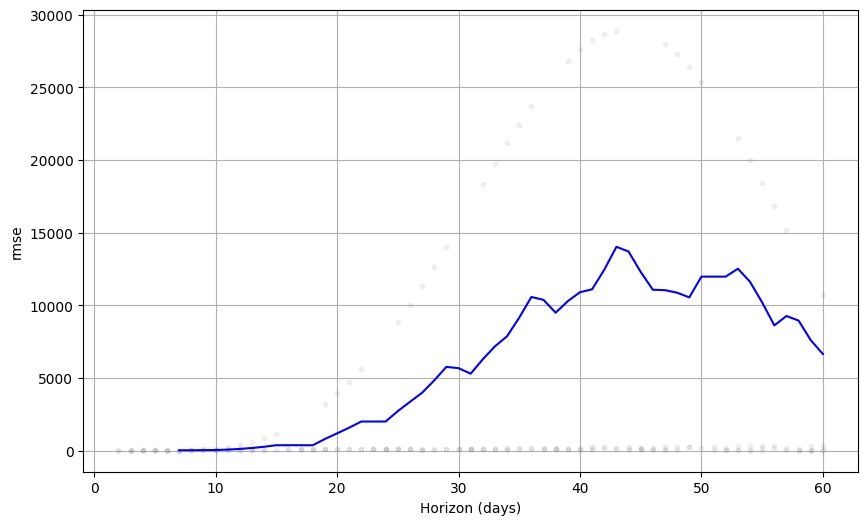

In [14]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')


## Creating Facebook Prophet Model

In [15]:
m=Prophet(**best_params,daily_seasonality=False)
m.fit(prophet_df)

##Forecasting

In [16]:
periods = 60
future=m.make_future_dataframe(periods)

In [17]:
forecast=m.predict(future)

In [18]:
forecast.head(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-09-29,1909.592686,1798.191488,1965.166740,1909.592686,1909.592686,-27.613520,-27.613520,-27.613520,-0.254889,-0.254889,-0.254889,-27.358631,-27.358631,-27.358631,0.0,0.0,0.0,1881.979166
1,2020-09-30,1908.970177,1796.913008,1957.980491,1908.970177,1908.970177,-29.052218,-29.052218,-29.052218,0.994210,0.994210,0.994210,-30.046428,-30.046428,-30.046428,0.0,0.0,0.0,1879.917959
2,2020-10-01,1908.347668,1797.746923,1958.783132,1908.347668,1908.347668,-32.005645,-32.005645,-32.005645,0.515625,0.515625,0.515625,-32.521270,-32.521270,-32.521270,0.0,0.0,0.0,1876.342023
3,2020-10-02,1907.725159,1790.090912,1954.064721,1907.725159,1907.725159,-34.238375,-34.238375,-34.238375,0.506193,0.506193,0.506193,-34.744568,-34.744568,-34.744568,0.0,0.0,0.0,1873.486784
4,2020-10-05,1905.857632,1783.258280,1945.738099,1905.857632,1905.857632,-41.378496,-41.378496,-41.378496,-1.777587,-1.777587,-1.777587,-39.600910,-39.600910,-39.600910,0.0,0.0,0.0,1864.479136
5,2020-10-06,1905.235123,1781.701568,1945.152194,1905.235123,1905.235123,-40.799604,-40.799604,-40.799604,-0.254889,-0.254889,-0.254889,-40.544716,-40.544716,-40.544716,0.0,0.0,0.0,1864.435519
6,2020-10-07,1904.612614,1786.508145,1941.700007,1904.612614,1904.612614,-40.138326,-40.138326,-40.138326,0.994210,0.994210,0.994210,-41.132536,-41.132536,-41.132536,0.0,0.0,0.0,1864.474288
7,2020-10-08,1903.990105,1785.779175,1948.723270,1903.990105,1903.990105,-40.848019,-40.848019,-40.848019,0.515625,0.515625,0.515625,-41.363644,-41.363644,-41.363644,0.0,0.0,0.0,1863.142086
8,2020-10-09,1903.367596,1776.146445,1946.938595,1903.367596,1903.367596,-40.737984,-40.737984,-40.737984,0.506193,0.506193,0.506193,-41.244177,-41.244177,-41.244177,0.0,0.0,0.0,1862.629612
9,2020-10-12,1901.500069,1778.541827,1942.072014,1901.500069,1901.500069,-40.718276,-40.718276,-40.718276,-1.777587,-1.777587,-1.777587,-38.940689,-38.940689,-38.940689,0.0,0.0,0.0,1860.781793


In [19]:
px.line(forecast, x='ds',y='yhat', title=f'{stock} Stock Forecast')

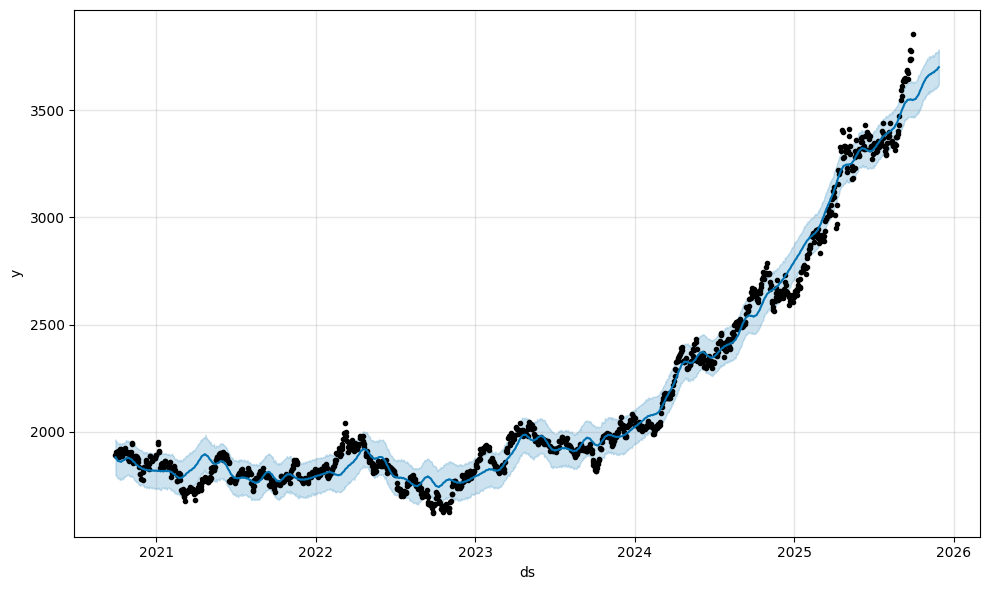

In [20]:
figure=m.plot(forecast, xlabel='ds', ylabel='y')

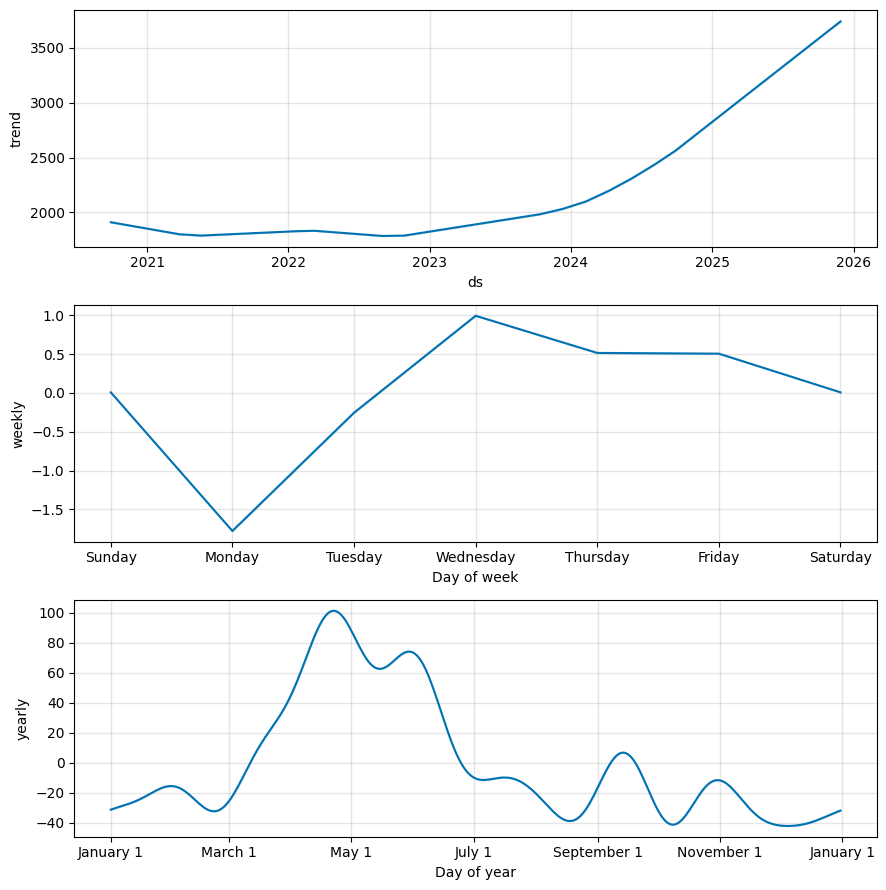

In [21]:
figure2=m.plot_components(forecast)

##Downloading the Forecast data

In [22]:
from google.colab import files
forecast.to_csv(f'{stock}_forecast.csv')
files.download(f'{stock}_forecast.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>